# Absolute Depth Estimation with ZoeDepth
You can also check [this](https://github.com/huggingface/transformers/issues/32381) issue

## ZoeDepth adds padding to the input during preprocessing

The original image


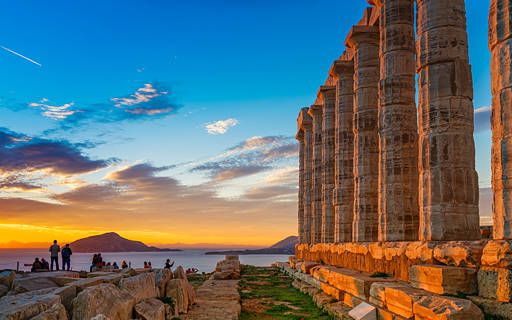

Default preprocessing adds "reflection" padding


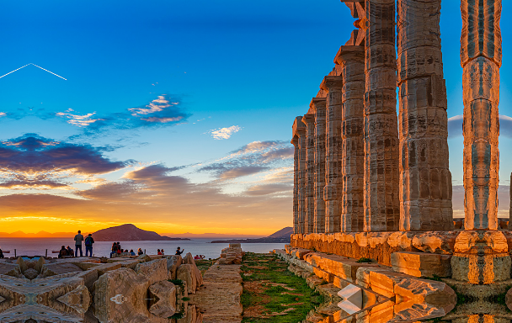

In [1]:
from transformers import AutoImageProcessor
from PIL import Image
import requests

url = "https://www.greece-is.com/wp-content/uploads/2016/07/ATH_RIVIERA_naos-poseidona-sounio-01.jpg"
image = Image.open(requests.get(url, stream=True).raw)

thmb = image.copy()
thmb.thumbnail((512, 512))
print('The original image')
thmb.show()

image_processor = AutoImageProcessor.from_pretrained("Intel/zoedepth-nyu")
img = image_processor(
    images=image, return_tensors="pt", do_normalize=False
)["pixel_values"].squeeze().permute(1, 2, 0).cpu().numpy()
pil = Image.fromarray((img * 255 / img.max()).astype("uint8"))
pil.thumbnail((512, 512))
print('Default preprocessing adds "reflection" padding')
pil.show()

## Transformers Implementation

In [2]:
from typing import Union, List, Tuple, Dict, Optional, Callable
from PIL import Image
import numpy as np
import torch
from torch.nn import functional as F
from transformers.models.zoedepth.modeling_zoedepth import ZoeDepthDepthEstimatorOutput

import matplotlib

def colorize(
    value: torch.Tensor | np.ndarray,
    vmin: Optional[float | None] = None,
    vmax: Optional[float | None] = None,
    vmin_perc: Optional[float] = 2.0,
    vmax_perc: Optional[float] = 98.0,
    cmap: Optional[str] = 'gray',
    invalid_val: Optional[int] = -99,
    invalid_mask: Optional[np.ndarray | None] = None,
    background_color: Optional[Tuple[int]] = (128, 128, 128, 255),
    gamma_corrected: Optional[bool] = False,
    value_transform: Optional[Callable | None] = None
):
    """Converts a depth map to a color image.

    Args:
        value (`torch.Tensor` or `numpy.ndarry`):
            Input depth map. Shape: (H, W) or (1, H, W) or (1, 1, H, W). All singular dimensions are squeezed
        vmin (`float`, *optional*):
            vmin-valued entries are mapped to start color of cmap. If None, value.min() is used. Defaults to None.
        vmax (`float`, *optional*):
            vmax-valued entries are mapped to end color of cmap. If None, value.max() is used. Defaults to None.
        vmin_perc (`float`, *optional*):
            use the `vmin_perc`-th percentile as `vmin`. Defaults to 2.0.
        vmax_perc (`float`, *optional*):
            use the `vmax_perc`-th percentile as `vmax`. Defaults to 98.0.
        cmap (`str`, *optional*):
            matplotlib colormap to use. Defaults to 'magma_r'.
        invalid_val (`int`, *optional*):
            Specifies value of invalid pixels that should be colored as 'background_color'. Defaults to -99.
        invalid_mask (`numpy.ndarray`, *optional*):
            Boolean mask for invalid regions. Defaults to None.
        background_color (`Tuple[int]`, *optional*):
            4-tuple RGB color to give to invalid pixels. Defaults to (128, 128, 128, 255).
        gamma_corrected (`bool`, *optional*):
            Apply gamma correction to colored image. Defaults to False.
        value_transform (Callable, *optional*):
            Apply transform function to valid pixels before coloring. Defaults to None.

    Returns:
        `numpy.ndarray`, dtype - uint8: Colored depth map. Shape: (H, W, 4)
    """
    if isinstance(value, torch.Tensor):
        value = value.detach().cpu().numpy()

    value = value.squeeze()
    if invalid_mask is None:
        invalid_mask = value == invalid_val
    mask = np.logical_not(invalid_mask)

    # normalize
    vmin = np.percentile(value[mask], vmin_perc) if vmin is None else vmin
    vmax = np.percentile(value[mask], vmax_perc) if vmax is None else vmax
    if vmin != vmax:
        value = (value - vmin) / (vmax - vmin)  # vmin..vmax
        # value = value / vmax  # vmin..vmax
    else:
        # Avoid 0-division
        value = value * 0.

    # squeeze last dim if it exists
    # grey out the invalid values

    value[invalid_mask] = np.nan
    cmapper = matplotlib.colormaps.get_cmap(cmap)
    if value_transform:
        value = value_transform(value)
        # value = value / value.max()
    value = cmapper(value, bytes=True)  # (nxmx4)

    # img = value[:, :, :]
    img = value[...]
    img[invalid_mask] = background_color

    #     return img.transpose((2, 0, 1))
    if gamma_corrected:
        # gamma correction
        img = img / 255
        img = np.power(img, 2.2)
        img = img * 255
        img = img.astype(np.uint8)

    return img


def post_process_depth_estimation_zoedepth(
    outputs: List[ZoeDepthDepthEstimatorOutput],
    source_sizes: torch.Tensor | List[Tuple[int, int]],
    target_sizes: Optional[torch.Tensor | List[Tuple[int, int]] | None] = None,
    outputs_flip: Optional[List[ZoeDepthDepthEstimatorOutput] | None] = None,
    remove_padding: Optional[bool] = True,

    vmin_perc: Optional[float] = 1.0,
    vmax_perc: Optional[float] = 99.0,
    cmap: Optional[str] = 'gray',
    gamma_corrected: Optional[bool] = False,
) -> List[Dict] :
    """
    Converts the raw output of [`ZoeDepthDepthEstimatorOutput`] into final depth predictions and depth PIL image.
    Only supports PyTorch.

    Args:
        outputs ([`ZoeDepthDepthEstimatorOutput`]):
            Raw outputs of the model.
        outputs_flip ([`ZoeDepthDepthEstimatorOutput`], *optional*):
            Raw outputs of the model from flipped input (averaged out in the end).
        source_sizes (`torch.Tensor` or `List[Tuple[int, int]]`):
            Tensor of shape `(batch_size, 2)` or list of tuples (`Tuple[int, int]`) containing the source size
            (height, width) of each image in the batch before preprocessing.
        target_sizes (`torch.Tensor` or `List[Tuple[int, int]]`, *optional*):
            Tensor of shape `(batch_size, 2)` or list of tuples (`Tuple[int, int]`) containing the target size
            (height, width) of each image in the batch. If left to None, predictions will not be resized.
        remove_padding (`bool`):
            By default ZoeDepth addes padding to fix the boundary artifacts in the output depth map, so we need
            remove this padding during post_processing. The parameter exists here in case the user changed the
            image preprocessing to not include padding.

        vmin_perc (`float`, *optional*):
            use the `vmin_perc`-th percentile as minimum value during normalization. Defaults to 2.0.
        vmax_perc (`float`, *optional*):
            use the `vmax_perc`-th percentile as maximum value during normalization. Defaults to 98.0.
        cmap (`str`, *optional*):
            matplotlib colormap to use. Defaults to 'magma_r'.
        gamma_corrected (`bool`, *optional*):
            Apply gamma correction to colored image. Defaults to False.

    Returns:
        `List[Dict]`: A list of dictionaries, each dictionary containing the depth predictions and a depth PIL
        image as predicted by the model.
    """
    predicted_depth = outputs.predicted_depth

    if (outputs_flip is not None) and (predicted_depth.shape != outputs_flip.predicted_depth.shape):
        raise ValueError(
            "Make sure that `outputs` and `outputs_flip` have the same shape"
        )

    if (target_sizes is not None) and (len(predicted_depth) != len(target_sizes)):
        raise ValueError(
            "Make sure that you pass in as many target sizes as the batch dimension of the predicted depth"
        )

    if (source_sizes is None) or (len(predicted_depth) != len(source_sizes)):
        raise ValueError(
            "Make sure that you pass in as many source image sizes as the batch dimension of the logits"
        )

    if outputs_flip is not None:
        predicted_depth = torch.stack([predicted_depth, outputs_flip.predicted_depth], dim=1)
    else:
        predicted_depth = predicted_depth.unsqueeze(1)

    # Zoe Depth model adds padding around the images to fix the boundary artifacts in the output depth map
    # The padding length is `int(np.sqrt(img_h/2) * fh)` for the height and similar for the width
    # fh (and fw respectively) are equal to '3' by default
    # Check [here](https://github.com/isl-org/ZoeDepth/blob/edb6daf45458569e24f50250ef1ed08c015f17a7/zoedepth/models/depth_model.py#L57)
    # for the original implementation.
    # In this section, we remove this padding to get the final depth image and depth prediction
    if isinstance(source_sizes, List):
        img_h = torch.Tensor([i[0] for i in source_sizes])
        img_w = torch.Tensor([i[1] for i in source_sizes])
    else:
        img_h, img_w = source_sizes.unbind(1)

    fh = fw = 3

    results = []
    for i, (d, s) in enumerate(zip(predicted_depth, source_sizes)):
        if remove_padding:
            pad_h = int(np.sqrt(s[0]/2) * fh)
            pad_w = int(np.sqrt(s[1]/2) * fw)
            d = F.interpolate(
                d.unsqueeze(1), size=[s[0] + 2*pad_h, s[1] + 2*pad_w],
                mode="bicubic", align_corners=False
            )
    
            if pad_h > 0:
                d = d[:, :, pad_h:-pad_h, :]
            if pad_w > 0:
                d = d[:, :, :, pad_w:-pad_w]

        if target_sizes is not None:
            target_size = target_sizes[i]
            d = F.interpolate(d, size=target_size, mode="bicubic", align_corners=False)

        if outputs_flip != None:
            d, d_f = d.chunk(2)
            d = (d + torch.flip(d_f, dims=[-1])) / 2

        d = d.squeeze().cpu().numpy()
        pil = Image.fromarray(colorize(
            d, vmin_perc=vmin_perc, vmax_perc=vmax_perc, cmap=cmap, gamma_corrected=gamma_corrected
        ))
        results.append({"predicted_depth": d, "depth": pil})

    return results

Input image size (h, w): (600, 960)
Output predicted depth shape (h, w): (600, 960)
Output depth image size (h, w): (600, 960)


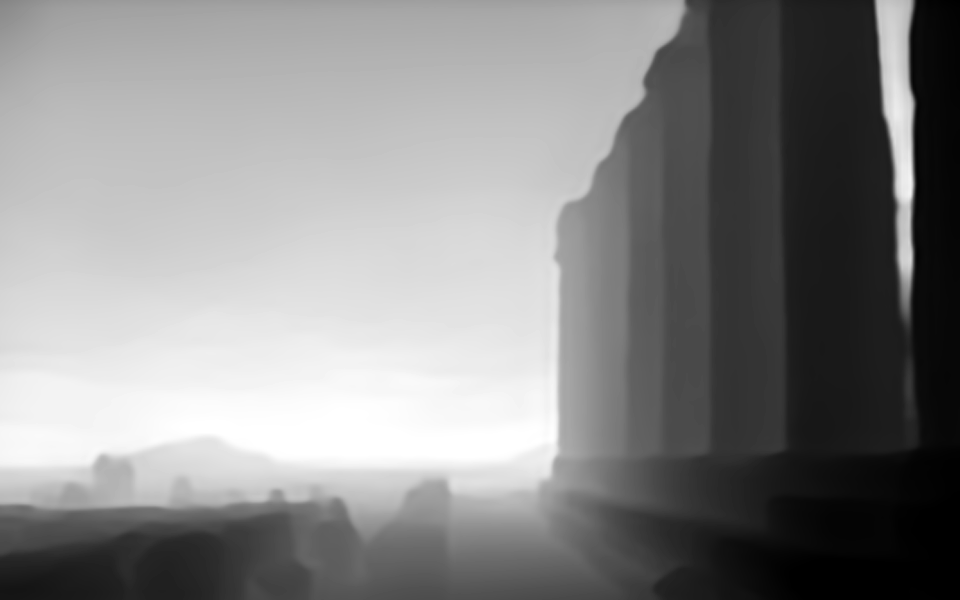

In [3]:
from PIL import Image
import requests

import torch
import numpy as np
from transformers import AutoImageProcessor, ZoeDepthForDepthEstimation

image_processor = AutoImageProcessor.from_pretrained("Intel/zoedepth-nyu")
model = ZoeDepthForDepthEstimation.from_pretrained("Intel/zoedepth-nyu")

# prepare image for the model

url = "https://www.greece-is.com/wp-content/uploads/2016/07/ATH_RIVIERA_naos-poseidona-sounio-01.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = image_processor(images=[image, image], return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    outputs_flip = model(pixel_values=torch.flip(inputs.pixel_values, dims=[3]))

processed_output = post_process_depth_estimation_zoedepth(
    outputs, [image.size[::-1]]*2, outputs_flip=outputs_flip, cmap="gray"
)[0]

print("Input image size (h, w):", image.size[::-1])
print("Output predicted depth shape (h, w):", processed_output["predicted_depth"].shape)
print("Output depth image size (h, w):", processed_output["depth"].size[::-1])
processed_output["depth"].show()

## Official Implementation

Using cache found in /home/zeus/.cache/torch/hub/isl-org_ZoeDepth_main
Using cache found in /home/zeus/.cache/torch/hub/intel-isl_MiDaS_master


img_size [384, 512]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully
Input image size (h, w): (600, 960)
Output predicted depth shape (h, w): (600, 960)
Output depth image size (h, w): (600, 960)


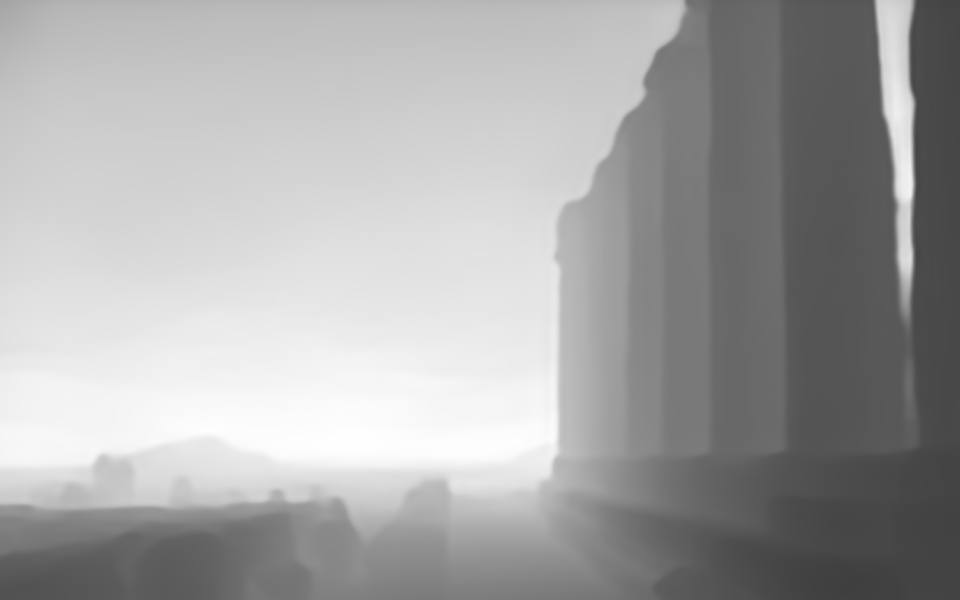

In [4]:
from PIL import Image
import requests

import torch

model = torch.hub.load('isl-org/ZoeDepth', "ZoeD_N", pretrained=True).eval()

url = "https://www.greece-is.com/wp-content/uploads/2016/07/ATH_RIVIERA_naos-poseidona-sounio-01.jpg"
image = Image.open(requests.get(url, stream=True).raw)

orig_output = model.infer_pil(image, output_type="numpy")
orig_pil = Image.fromarray((orig_output * 255 / orig_output.max()).astype("uint8"))

print("Input image size (h, w):", image.size[::-1])
print("Output predicted depth shape (h, w):", orig_output.shape)
print("Output depth image size (h, w):", orig_pil.size[::-1])
orig_pil.show()

## Discrepancy between the two implementations

Max error: 7.009506e-05
Min error: -4.36306e-05
MSE: 1.9103899e-11
RMSE: 4.3708005e-06
MAE: 3.4950078e-06


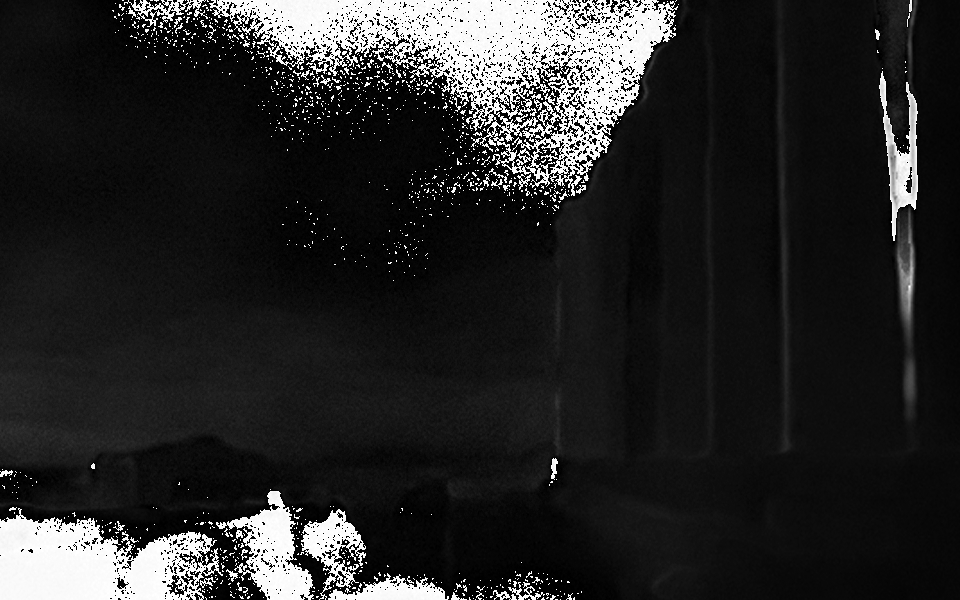

In [5]:
import numpy as np
from PIL import Image

error = orig_output - processed_output["predicted_depth"]

print("Max error:", error.max())
print("Min error:", error.min())
print("MSE:", (error**2).mean())
print("RMSE:", np.sqrt((error**2).mean()))
print("MAE:", (np.abs(error).mean()))

Image.fromarray((error * 255 / error.max()).astype("uint8")).show()